In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from esda.moran import Moran, Moran_Local
from libpysal.weights import Queen
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx
import warnings
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.colors import Normalize,ListedColormap
import networkx as nx
from geopy.distance import geodesic
from scipy.spatial.distance import cdist
import random

In [5]:
warnings.filterwarnings('ignore')

In [6]:
data=pd.read_csv('Preprocessed_Dataset.csv')

In [7]:
# 2. Normalize Variables
# Select columns for pollutants
pollutant_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
scaler = MinMaxScaler()
data[pollutant_columns] = scaler.fit_transform(data[pollutant_columns])

In [8]:
data.head()

Measurement date  Station code  \
0  2017-01-01 00:00:00           101   
1  2017-01-01 01:00:00           101   
2  2017-01-01 02:00:00           101   
3  2017-01-01 03:00:00           101   
4  2017-01-01 04:00:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2       NO2        O3        CO      PM10     PM2.5  
0  0.500  0.830986  0.027027  0.475711  0.737374  0.934426  
1  0.500  0.816901  0.027027  0.475711  0.717172  0.967213  
2  0.500  0.788732  0.027027  0.475711  0.707071  0.967213  
3  0.500  0.788732  0.027027  0.475711  0.707071  0.950820  
4  0.375  0.718310  0.027027  0.475711  0.696970  1.000000

In [9]:
# 3. Aggregate Data by Day (or desired time scale)
# Convert the measurement date to datetime
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Aggregate pollutants by daily averages for each station
daily_data = data.groupby(['Station code', data['Measurement date'].dt.date])[pollutant_columns].mean().reset_index()
daily_data.rename(columns={'Measurement date': 'Date'}, inplace=True)

In [10]:
# Save the processed data
daily_data.to_csv('Daily_Averaged_Pollutants.csv', index=False)

In [11]:
daily_data.head()

Station code        Date       SO2       NO2        O3        CO      PM10  \
0           101  2017-01-01  0.526042  0.764085  0.042230  0.786204  0.824916   
1           101  2017-01-02  0.598958  0.651408  0.221284  0.895712  0.878314   
2           101  2017-01-03  0.604167  0.658451  0.187500  0.766618  0.677031   
3           101  2017-01-04  0.671875  0.797535  0.118243  0.810311  0.516414   
4           101  2017-01-05  0.541667  0.582160  0.148649  0.560068  0.352273   

      PM2.5  
0  0.962963  
1  0.940270  
2  0.726890  
3  0.572404  
4  0.359973

In [12]:
stations = pd.DataFrame({
    'Station code': data['Station code'].unique(),
    'Latitude': data.groupby('Station code')['Latitude'].first().values,
    'Longitude': data.groupby('Station code')['Longitude'].first().values,
})

In [13]:
# 1. Convert to GeoDataFrame for Spatial Analysis
gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.Longitude, stations.Latitude))
gdf.crs = "EPSG:4326"  # Set coordinate reference system

In [14]:
# Ensure 'Date' column in daily_data is in datetime format
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

In [15]:
# # Define the specific date for filtering
# specific_date = pd.Timestamp('2017-01-01')  # Ensure this is a datetime object
# daily_pollutants = daily_data[daily_data['Date'] == specific_date]
# gdf = gdf.merge(daily_pollutants, on='Station code', how='inner')
# w = Queen.from_dataframe(gdf)
# # Global Moran’s I for spatial autocorrelation
# moran_results = {}
# for pollutant in pollutant_columns:
#     moran = Moran(gdf[pollutant], w)
#     moran_results[pollutant] = moran.I
# for pollutant, i in moran_results.items():
#     print(f"{pollutant}: Moran's I = {i:.4f}")
# # Local Moran’s I for hotspot detection
# for pollutant in pollutant_columns:
#     local_moran = Moran_Local(gdf[pollutant], w)
#     gdf[f'{pollutant}_Local_I'] = local_moran.Is
#     gdf[f'{pollutant}_Significant'] = local_moran.p_sim < 0.05
# # Plot hotspots for each pollutant
# for pollutant in pollutant_columns:
#     plt.figure(figsize=(12, 8))
#     gdf.plot(column=f'{pollutant}_Local_I', cmap='coolwarm', legend=True, edgecolor='black')
#     ctx.add_basemap(plt.gca(), crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
#     plt.title(f'Hotspot Map for {pollutant} ({specific_date.date()})')
#     plt.show()

In [16]:
# Initialize an empty list to store results for Global Moran's I
global_moran_results = []
local_moran_results = []

# Loop through all unique dates
for specific_date in daily_data['Date'].unique():
    
    # Filter data for the current date
    daily_pollutants = daily_data[daily_data['Date'] == specific_date]
    
    # Merge pollutant data with GeoDataFrame
    gdf_date = gdf.merge(daily_pollutants, on='Station code', how='inner')
    
    # Calculate spatial weights (Queen contiguity-based)
    w = Queen.from_dataframe(gdf_date)
    
    # Calculate Global Moran’s I for each pollutant
    date_moran_results = {'Date': specific_date}
    for pollutant in pollutant_columns:
        moran = Moran(gdf_date[pollutant], w)
        date_moran_results[pollutant] = moran.I
    
    global_moran_results.append(date_moran_results)
    
    # Calculate Local Moran’s I for each pollutant and save the GeoDataFrame
    for pollutant in pollutant_columns:
        local_moran = Moran_Local(gdf_date[pollutant], w)
        for idx, station_code in enumerate(gdf_date['Station code']):
            local_moran_results.append({
                'Date': specific_date,
                'Station code': station_code,
                'Pollutant': pollutant,
                'Local_I': local_moran.Is[idx],
                'Significant': local_moran.p_sim[idx] < 0.05
            })

In [17]:
# Save Global Moran's I results to a CSV
global_moran_df = pd.DataFrame(global_moran_results)

In [18]:
print(global_moran_df.head())

        Date       SO2       NO2        O3        CO      PM10     PM2.5
0 2017-01-01  0.012306  0.099092  0.141451  0.083659 -0.073803 -0.205986
1 2017-01-02  0.010452 -0.007732  0.138366  0.170632 -0.127145 -0.178340
2 2017-01-03 -0.143355  0.074552  0.241532 -0.011719  0.202131 -0.097732
3 2017-01-04 -0.190929  0.082717  0.128861  0.100014 -0.034586  0.010744
4 2017-01-05 -0.178067  0.072802  0.025548  0.071037  0.006530 -0.066548


In [19]:
# Save Local Moran's I results to a CSV
local_moran_df = pd.DataFrame(local_moran_results)

In [20]:
print(local_moran_df.head())

        Date  Station code Pollutant   Local_I  Significant
0 2017-01-01           101       SO2  0.047156        False
1 2017-01-01           102       SO2 -0.026244        False
2 2017-01-01           103       SO2  0.101919        False
3 2017-01-01           104       SO2  0.023844        False
4 2017-01-01           105       SO2  0.008587        False


In [21]:
# Extract unique stations with their coordinates
stations = data[['Station code', 'Latitude', 'Longitude']].drop_duplicates()

In [22]:
# Merge station coordinates with Local Moran's I results
local_moran_df = local_moran_df.merge(stations, on='Station code', how='left')

In [23]:
# Convert to GeoDataFrame
local_moran_df['geometry'] = gpd.points_from_xy(local_moran_df['Longitude'], local_moran_df['Latitude'])
gdf = gpd.GeoDataFrame(local_moran_df, geometry='geometry', crs="EPSG:4326")

In [24]:
print(gdf.head())

        Date  Station code Pollutant   Local_I  Significant   Latitude  \
0 2017-01-01           101       SO2  0.047156        False  37.572016   
1 2017-01-01           102       SO2 -0.026244        False  37.564263   
2 2017-01-01           103       SO2  0.101919        False  37.540033   
3 2017-01-01           104       SO2  0.023844        False  37.609823   
4 2017-01-01           105       SO2  0.008587        False  37.593742   

    Longitude                    geometry  
0  127.005008  POINT (127.00501 37.57202)  
1  126.974676  POINT (126.97468 37.56426)  
2  127.004850  POINT (127.00485 37.54003)  
3  126.934848  POINT (126.93485 37.60982)  
4  126.949679  POINT (126.94968 37.59374)  


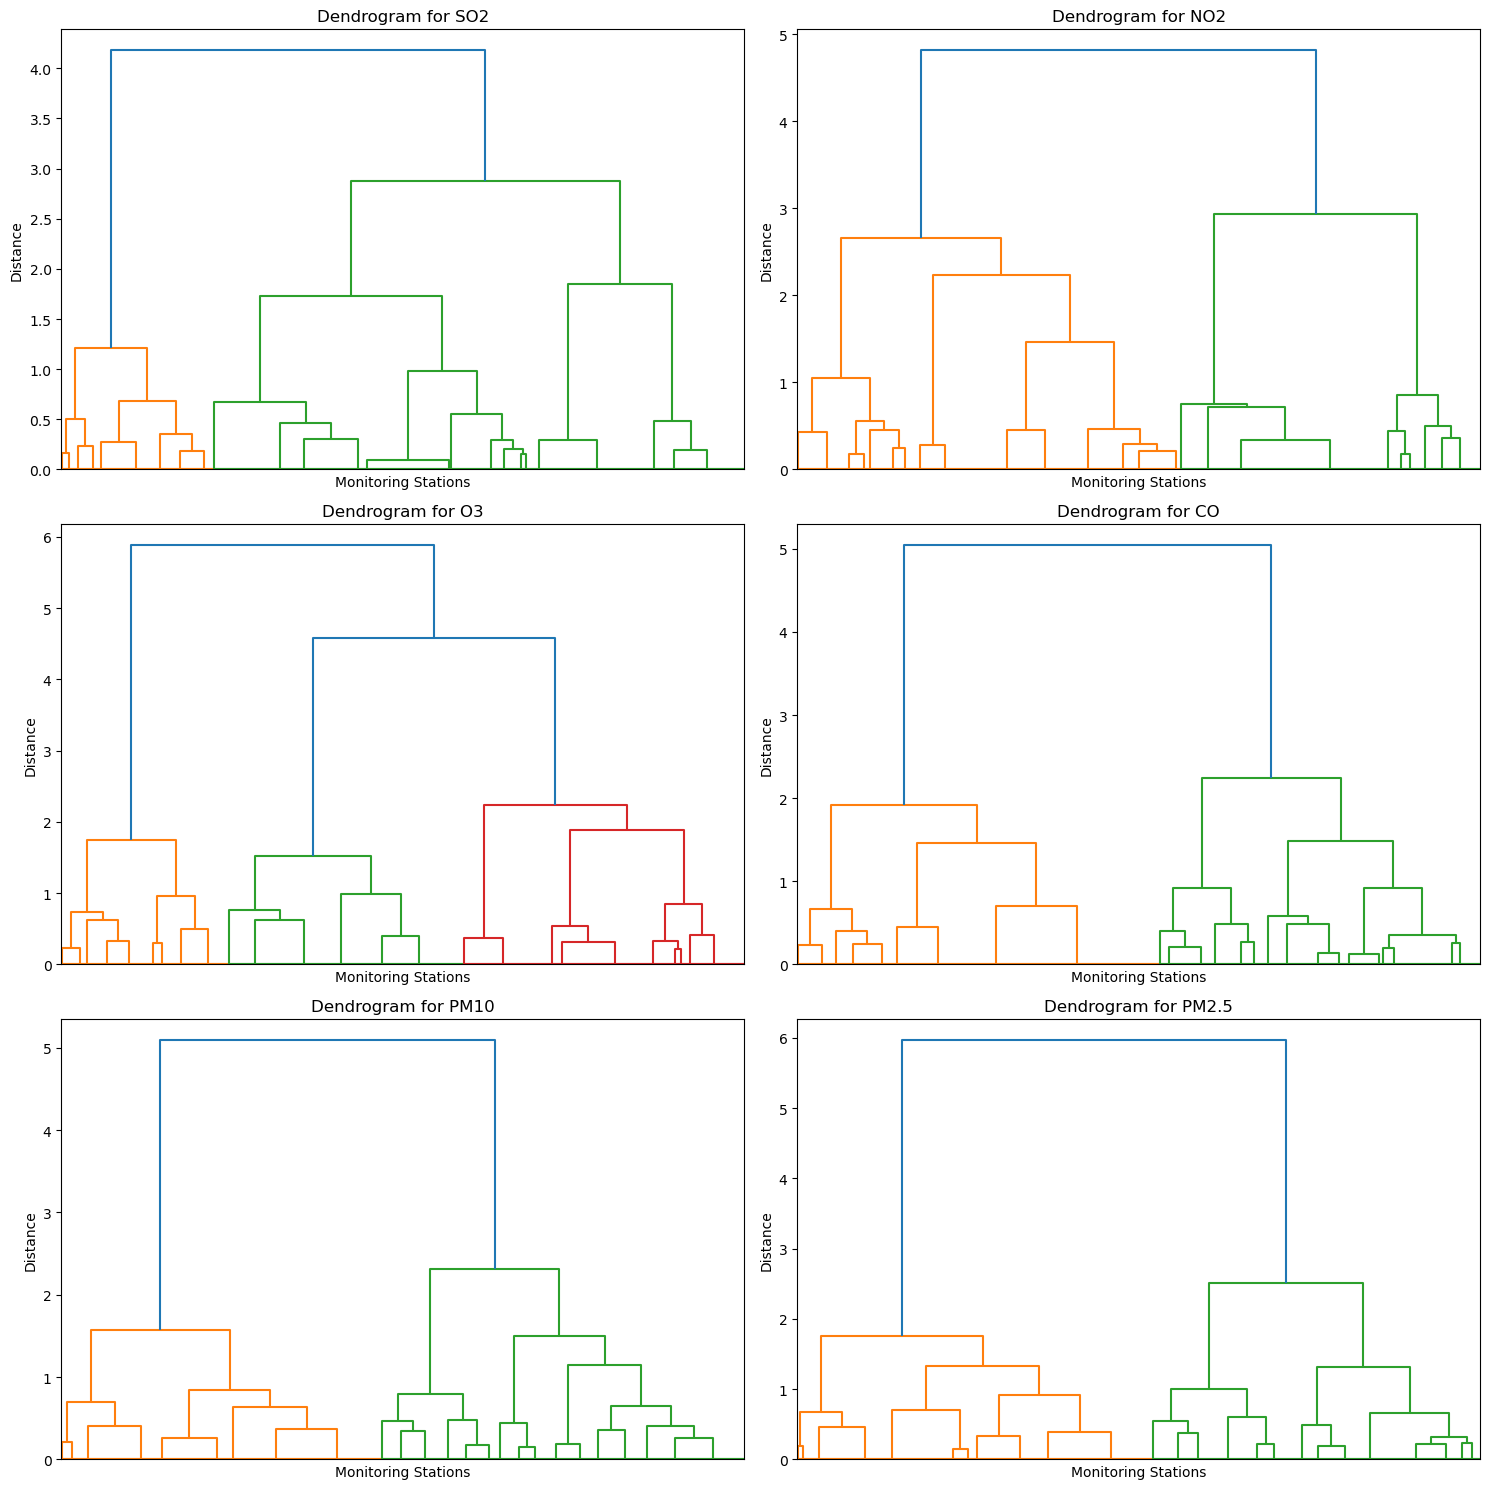

In [26]:
# Get the unique pollutants
pollutants = gdf['Pollutant'].unique()

# Create a 3x2 grid for subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Adjust size as needed
axes = axes.flatten()  # Flatten the 3x2 grid for easy indexing

# Loop through each pollutant and plot dendrogram
for i, pollutant in enumerate(pollutants[:6]):  # Limit to 6 pollutants
    # Filter data for the current pollutant
    pollutant_data = gdf[(gdf['Pollutant'] == pollutant) & gdf['Significant'] & (gdf['Local_I'] > 0)]
    
    # Prepare the coordinates for clustering
    coords = pollutant_data[['Latitude', 'Longitude']].to_numpy()
    
    # Perform hierarchical clustering
    Z = linkage(coords, method='ward')  # Ward's method for variance minimization
    
    # Plot dendrogram in the appropriate subplot
    dendrogram(Z, no_labels=True, ax=axes[i])  # Disable x-axis labels
    axes[i].set_title(f"Dendrogram for {pollutant}")
    axes[i].set_xlabel("Monitoring Stations")
    axes[i].set_ylabel("Distance")

# Adjust layout to avoid overlap
plt.tight_layout()

In [22]:
# Initialize a dictionary to store clustered results for each pollutant
clusters_by_pollutant = {}

<Figure size 1200x800 with 0 Axes>

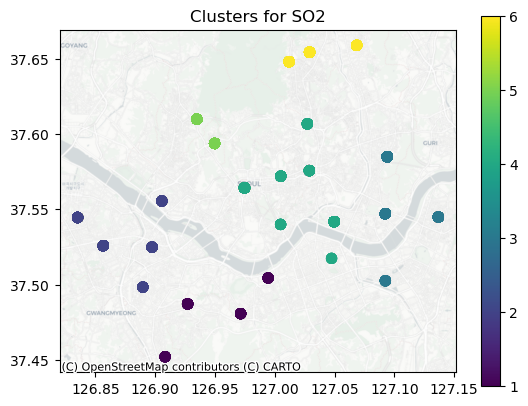

<Figure size 1200x800 with 0 Axes>

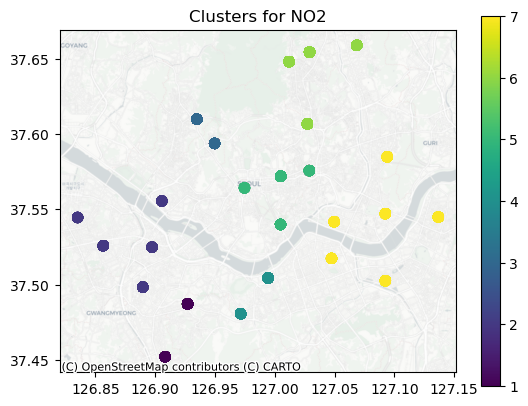

<Figure size 1200x800 with 0 Axes>

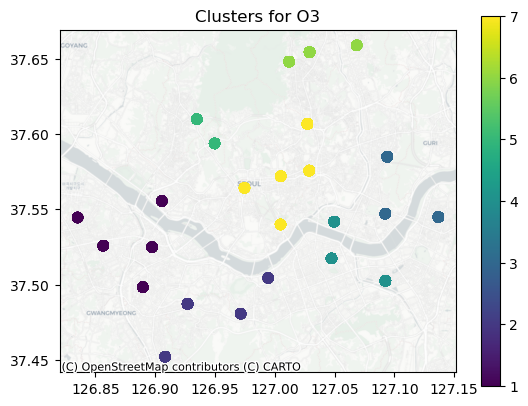

<Figure size 1200x800 with 0 Axes>

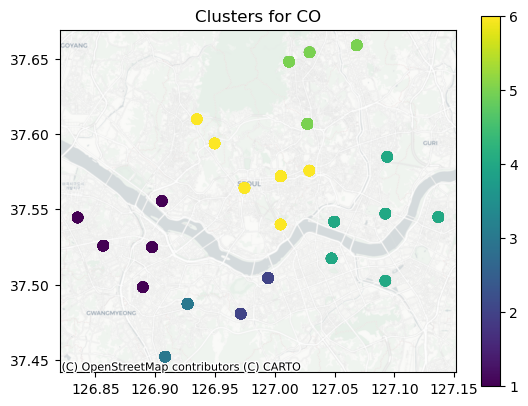

<Figure size 1200x800 with 0 Axes>

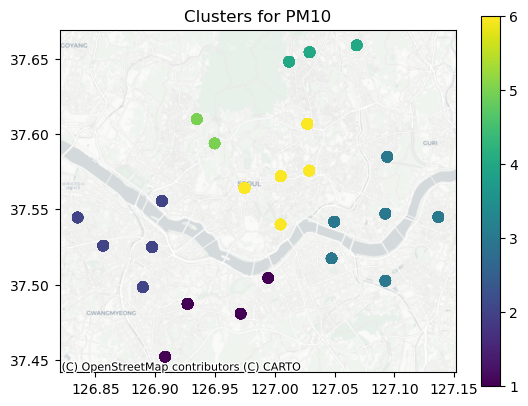

<Figure size 1200x800 with 0 Axes>

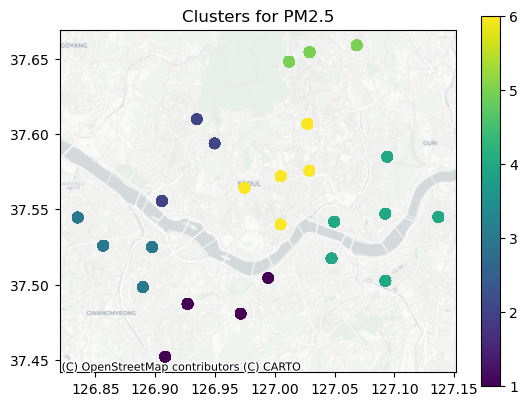

In [23]:
# Apply hierarchical clustering for each pollutant
for pollutant in gdf['Pollutant'].unique():
    # Filter data for the current pollutant
    pollutant_data = gdf[(gdf['Pollutant'] == pollutant) & gdf['Significant'] & (gdf['Local_I'] > 0)]
    
    # Prepare the coordinates for clustering
    coords = pollutant_data[['Latitude', 'Longitude']].to_numpy()

    # Perform hierarchical clustering
    Z = linkage(coords, method='ward')  # Ward's method for variance minimization

    # Set a distance threshold to determine clusters
    pollutant_data['Cluster'] = fcluster(Z, t=1, criterion='distance')

    # Store the clustered data for this pollutant
    clusters_by_pollutant[pollutant] = pollutant_data

    # Visualize clusters on a map
    plt.figure(figsize=(12, 8))
    ax = pollutant_data.plot(column='Cluster', cmap='viridis', legend=True, markersize=50, alpha=0.8)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    plt.title(f"Clusters for {pollutant}")
    plt.show()

    # Save clustered data to a GeoJSON file
    output_file = f'{pollutant}_Hierarchical_Clusters.geojson'
    pollutant_data.to_file(output_file, driver='GeoJSON')

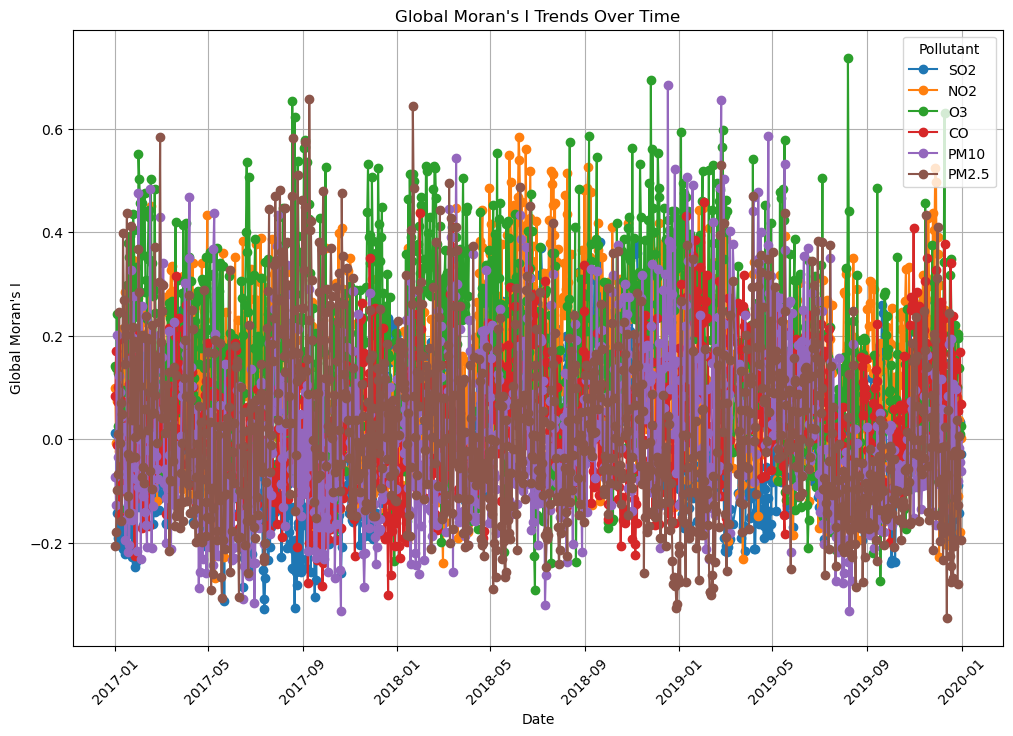

In [24]:
# Global Moran's I Trend Analysis
global_moran_df = pd.DataFrame(global_moran_results)

# Plot Global Moran’s I trend for each pollutant
plt.figure(figsize=(12, 8))
for pollutant in pollutants:
    plt.plot(
        global_moran_df['Date'],
        global_moran_df[pollutant],
        marker='o',
        label=pollutant
    )

plt.title("Global Moran's I Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Global Moran's I")
plt.legend(title="Pollutant")
plt.xticks(rotation=45)
plt.grid(True)

In [25]:
# Identify persistent hotspots
local_moran_df = pd.DataFrame(local_moran_results)

# Filter High-High clusters
high_high_clusters = local_moran_df[
    (local_moran_df['Significant'] == True) & (local_moran_df['Local_I'] > 0)
]


In [26]:
# Count occurrences of High-High clusters per station
persistent_hotspots = high_high_clusters.groupby(['Station code'])['Date'].count().reset_index()
persistent_hotspots.rename(columns={'Date': 'Hotspot_Frequency'}, inplace=True)

In [27]:
# Set a threshold for persistence (e.g., >=10 days)
threshold = 10
persistent_hotspots = persistent_hotspots[persistent_hotspots['Hotspot_Frequency'] >= threshold]

In [28]:
# Merge with station coordinates
persistent_hotspots = stations.merge(persistent_hotspots, on='Station code', how='inner')

In [29]:
# Save persistent hotspots to GeoJSON
gdf_persistent_hotspots = gpd.GeoDataFrame(
    persistent_hotspots,
    geometry=gpd.points_from_xy(persistent_hotspots['Longitude'], persistent_hotspots['Latitude']),
    crs="EPSG:4326"
)
gdf_persistent_hotspots.to_file('Persistent_Hotspots.geojson', driver='GeoJSON')

In [30]:
# Merge local Moran's I data with pollutant concentrations
heatmap_data = local_moran_df.merge(
    daily_data,
    on=['Station code', 'Date'],
    how='left'
)

In [31]:
daily_data.head()

Station code       Date       SO2       NO2        O3        CO      PM10  \
0           101 2017-01-01  0.526042  0.764085  0.042230  0.786204  0.824916   
1           101 2017-01-02  0.598958  0.651408  0.221284  0.895712  0.878314   
2           101 2017-01-03  0.604167  0.658451  0.187500  0.766618  0.677031   
3           101 2017-01-04  0.671875  0.797535  0.118243  0.810311  0.516414   
4           101 2017-01-05  0.541667  0.582160  0.148649  0.560068  0.352273   

      PM2.5  
0  0.962963  
1  0.940270  
2  0.726890  
3  0.572404  
4  0.359973

In [32]:
# Filter data for persistent hotspots
heatmap_data = heatmap_data[heatmap_data['Station code'].isin(persistent_hotspots['Station code'])]

In [33]:
heatmap_data.head()

Date  Station code Pollutant   Local_I  Significant       SO2  \
0 2017-01-01           101       SO2  0.047156        False  0.526042   
1 2017-01-01           102       SO2 -0.026244        False  0.677083   
2 2017-01-01           103       SO2  0.101919        False  0.630208   
3 2017-01-01           104       SO2  0.023844        False  0.729167   
4 2017-01-01           105       SO2  0.008587        False  0.656250   

        NO2        O3        CO      PM10     PM2.5  
0  0.764085  0.042230  0.786204  0.824916  0.962963  
1  0.798122  0.041104  0.826200  0.822391  0.927975  
2  0.549883  0.033784  0.802367  0.781566  0.905055  
3  0.587441  0.073761  0.651427  0.710017  0.727459  
4  0.542254  0.103041  0.746757  0.870113  0.801913

In [34]:
# Pivot data to create heatmap input
# Ensure one pollutant is processed at a time
heatmap_pivot = heatmap_data.pivot_table(
    index='Station code',  # Rows: Station codes
    columns='Date',        # Columns: Dates
    values='SO2'           # Example: Change to specific pollutant column, e.g., 'SO2', 'NO2', etc.
)

In [35]:
heatmap_pivot.head()

Date          2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
Station code                                                               
101             0.526042    0.598958    0.604167    0.671875    0.541667   
102             0.677083    0.697917    0.640625    0.635417    0.494792   
103             0.630208    0.760417    0.671875    0.692708    0.536458   
104             0.729167    0.807292    0.666667    0.593750    0.489583   
105             0.656250    0.703125    0.757812    0.750000    0.661458   

Date          2017-01-06  2017-01-07  2017-01-08  2017-01-09  2017-01-10  ...  \
Station code                                                              ...   
101             0.458333    0.578125    0.505208    0.583333    0.458333  ...   
102             0.411458    0.515625    0.411458    0.598958    0.432292  ...   
103             0.489583    0.609375    0.546875    0.656250    0.510417  ...   
104             0.406250    0.432292    0.447917    0.552083    0.359375  ...   
105             0.593750    0.625000    0.604167    0.734375    0.687500  ...   

Date          2019-12-22  2019-12-23  2019-12-24  2019-12-25  2019-12-26  \
Station code                                                               
101             0.557292    0.442708    0.484375    0.479167    0.463542   
102             0.427083    0.348958    0.385417    0.421875    0.380208   
103             0.432292    0.385417    0.390625    0.380208    0.406250   
104             0.395833    0.250000    0.276042    0.250000    0.333333   
105             0.750000    0.531250    0.833333    0.796875    0.546875   

Date          2019-12-27  2019-12-28  2019-12-29  2019-12-30  2019-12-31  
Station code                                                              
101             0.445312    0.531250    0.473958    0.421875    0.416667  
102             0.395833    0.453125    0.437500    0.385417    0.296875  
103             0.375000    0.421875    0.375000    0.375000    0.348958  
104             0.421875    0.437500    0.369792    0.380208    0.375000  
105             0.453125    0.473958    0.333333    0.286458    0.302083  

[5 rows x 1085 columns]

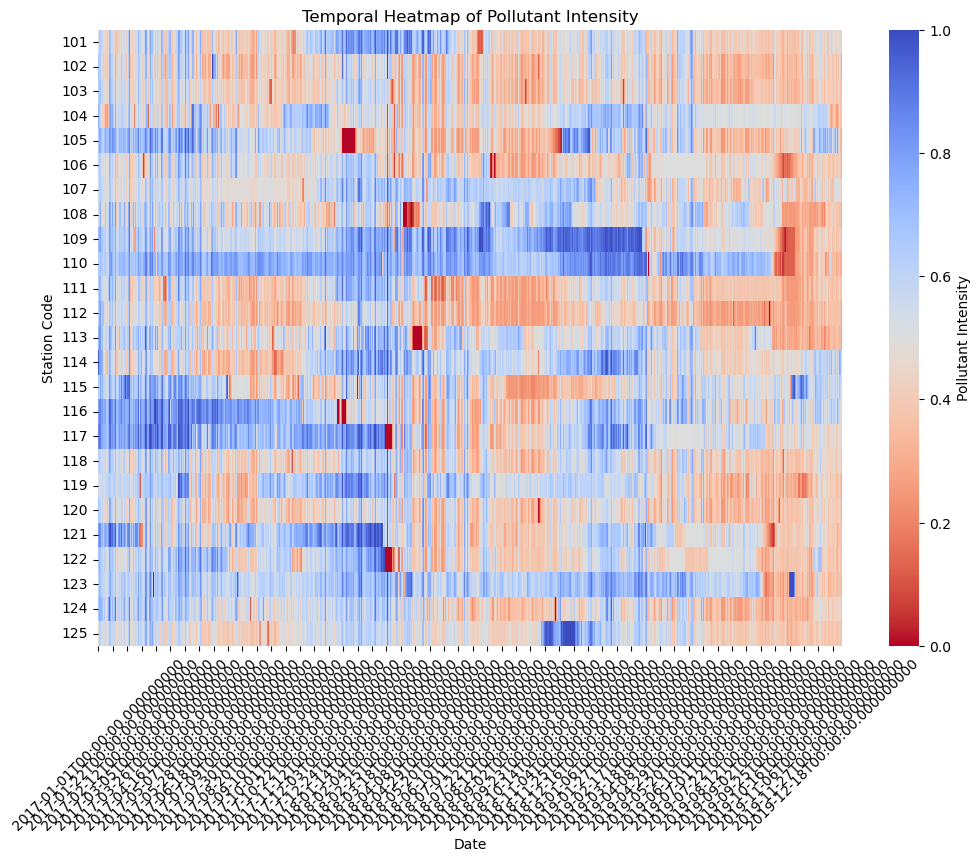

In [36]:
# Replot the heatmap with adjustments
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_pivot,
    cmap='coolwarm_r',
    vmin=0,  # Adjust based on data range
    vmax=1,  # Adjust based on data range
    cbar_kws={'label': 'Pollutant Intensity'}
)
plt.title("Temporal Heatmap of Pollutant Intensity")
plt.xlabel("Date")
plt.ylabel("Station Code")
plt.xticks(rotation=45)
plt.show()

In [37]:
daily_data.head()

Station code       Date       SO2       NO2        O3        CO      PM10  \
0           101 2017-01-01  0.526042  0.764085  0.042230  0.786204  0.824916   
1           101 2017-01-02  0.598958  0.651408  0.221284  0.895712  0.878314   
2           101 2017-01-03  0.604167  0.658451  0.187500  0.766618  0.677031   
3           101 2017-01-04  0.671875  0.797535  0.118243  0.810311  0.516414   
4           101 2017-01-05  0.541667  0.582160  0.148649  0.560068  0.352273   

      PM2.5  
0  0.962963  
1  0.940270  
2  0.726890  
3  0.572404  
4  0.359973

In [38]:
# Add 'Month' column to daily data
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month

In [39]:
# Reshape data: Convert wide format (pollutants as columns) to long format
melted_data = daily_data.melt(
    id_vars=['Station code', 'Date', 'Month'],  # Non-pollutant columns
    value_vars=pollutant_columns,  # Pollutant columns to reshape
    var_name='Pollutant',  # New column for pollutant names
    value_name='Concentration'  # New column for pollutant concentrations
)

In [40]:
# Calculate monthly averages
monthly_avg = melted_data.groupby(['Pollutant', 'Month'])['Concentration'].mean().reset_index()

([<matplotlib.axis.XTick at 0x18d2afa3350>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sep'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

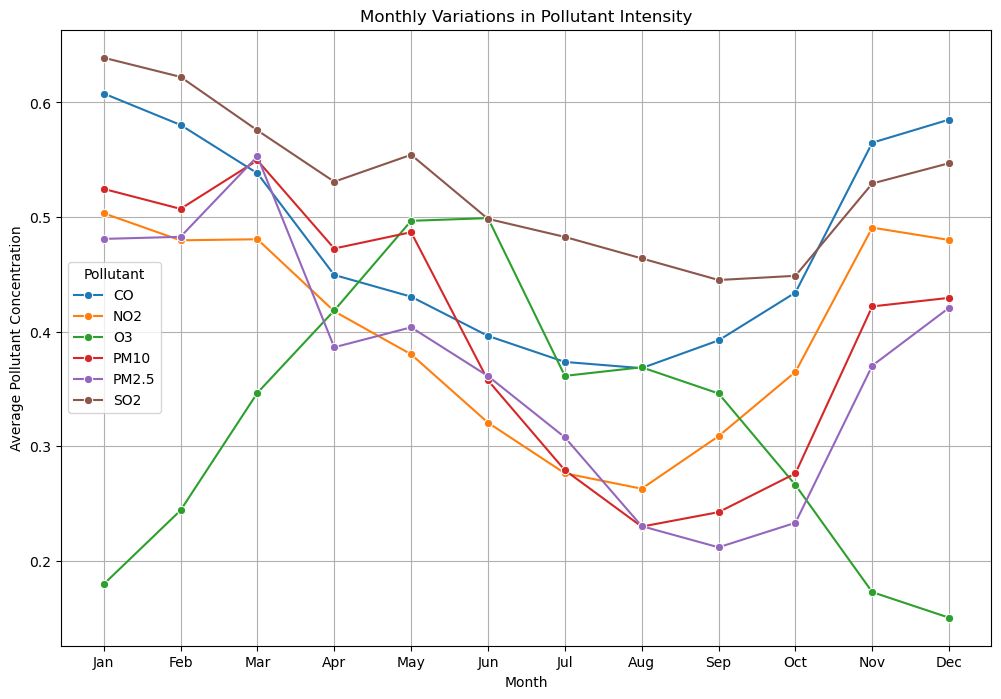

In [41]:
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=monthly_avg,
    x='Month',
    y='Concentration',
    hue='Pollutant',
    marker='o'
)
plt.title("Monthly Variations in Pollutant Intensity")
plt.xlabel("Month")
plt.ylabel("Average Pollutant Concentration")
plt.legend(title="Pollutant")
plt.grid(True)
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

In [42]:
# Define a season mapping
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [43]:
# Add 'Season' column
melted_data['Season'] = melted_data['Month'].apply(get_season)

# Calculate seasonal averages
seasonal_avg = melted_data.groupby(['Pollutant', 'Season'])['Concentration'].mean().reset_index()

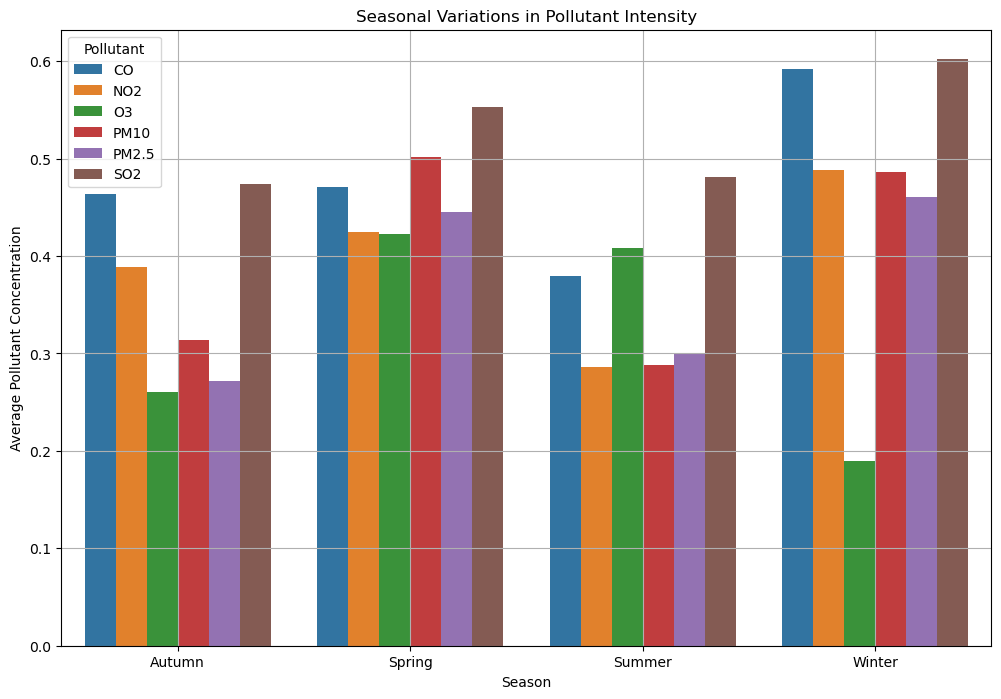

In [44]:
# Plot seasonal variations for each pollutant
plt.figure(figsize=(12, 8))
sns.barplot(
    data=seasonal_avg,
    x='Season',
    y='Concentration',
    hue='Pollutant'
)
plt.title("Seasonal Variations in Pollutant Intensity")
plt.xlabel("Season")
plt.ylabel("Average Pollutant Concentration")
plt.legend(title="Pollutant")
plt.grid(True)

In [45]:
# Create a GeoDataFrame by merging pollutant concentrations with spatial data
choropleth_gdf = gdf.merge(daily_data, on='Station code', how='left')

<Figure size 1200x800 with 0 Axes>

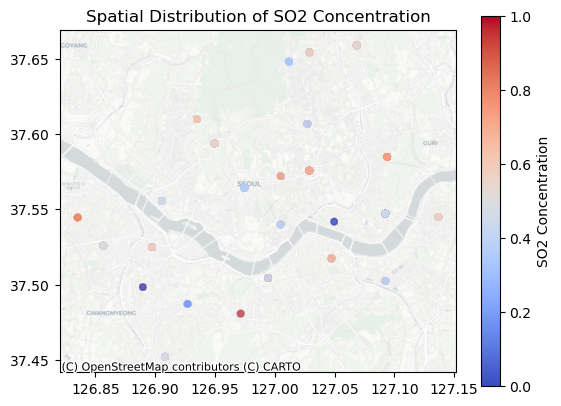

<Figure size 1200x800 with 0 Axes>

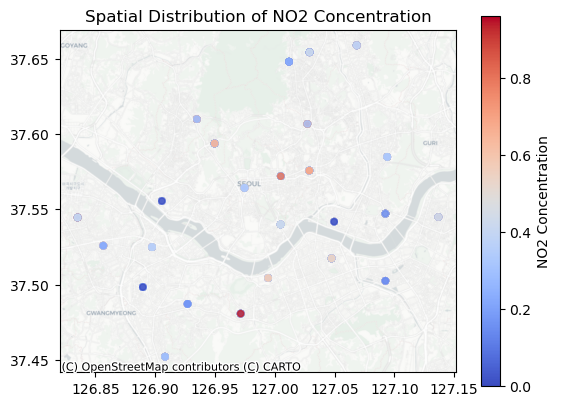

<Figure size 1200x800 with 0 Axes>

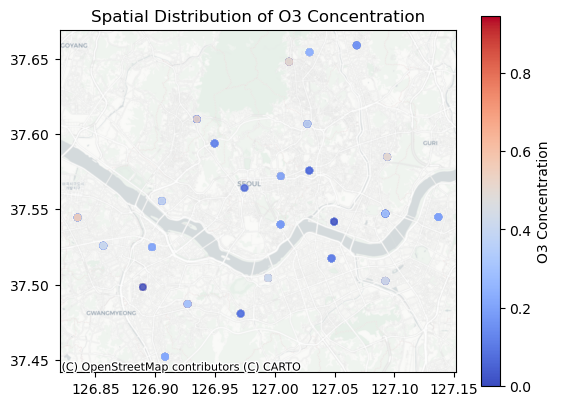

<Figure size 1200x800 with 0 Axes>

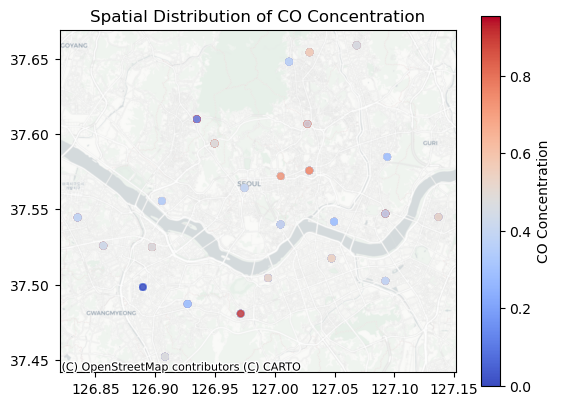

<Figure size 1200x800 with 0 Axes>

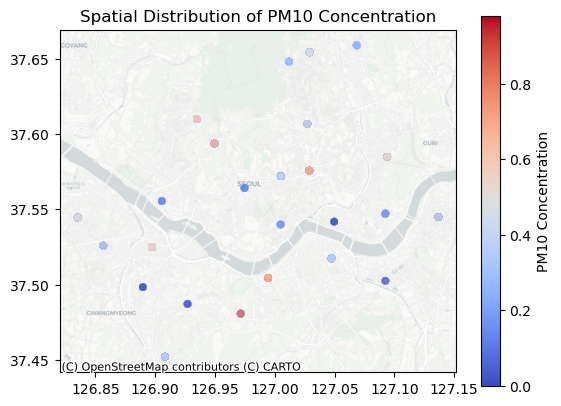

<Figure size 1200x800 with 0 Axes>

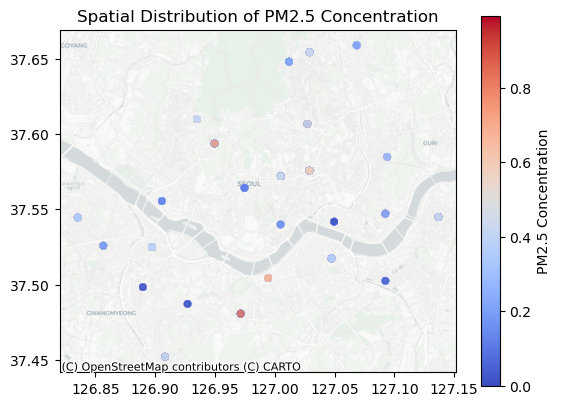

In [46]:
# Define the sample size
sample_size = 1000

# Sample the data
sampled_gdf = choropleth_gdf.sample(n=sample_size, random_state=42)

# Loop through each pollutant and generate a map
for pollutant in pollutants:
    plt.figure(figsize=(12, 8))
    ax = sampled_gdf.plot(
        column=pollutant,
        cmap='coolwarm',
        legend=True,
        legend_kwds={'label': f'{pollutant} Concentration'},
        markersize=20,  # Adjust marker size as needed
        alpha=0.8
    )
    ctx.add_basemap(ax, crs=sampled_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    plt.title(f"Spatial Distribution of {pollutant} Concentration")
    plt.show()

In [47]:
# Pivot data for heatmap input
seasonal_data = melted_data.groupby(['Season', 'Pollutant'])['Concentration'].mean().reset_index()
seasonal_pivot = seasonal_data.pivot_table(index='Pollutant', columns='Season', values='Concentration')

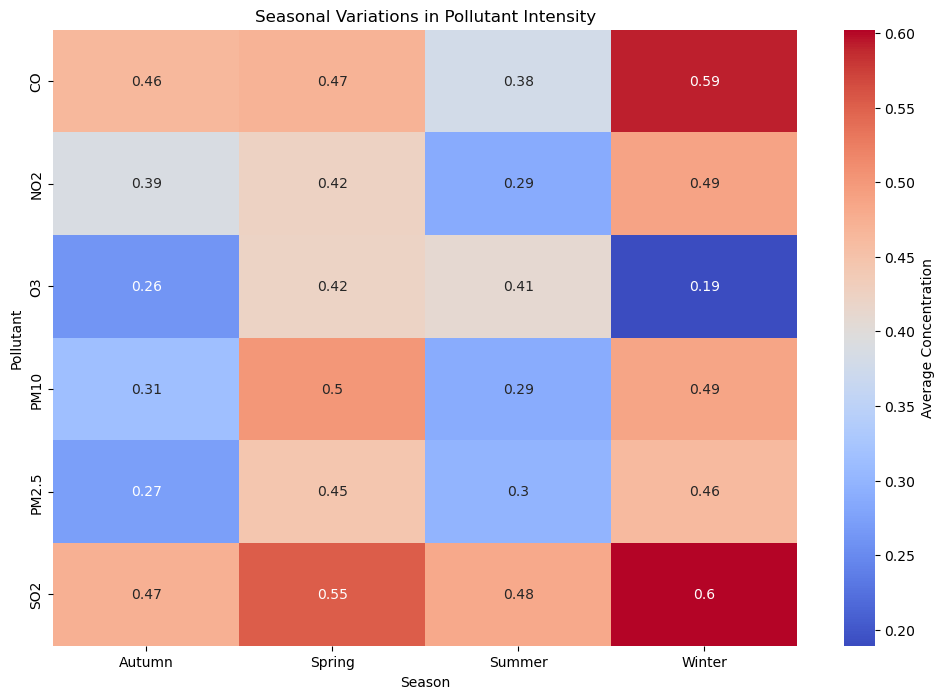

In [48]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    seasonal_pivot,
    cmap='coolwarm',
    cbar_kws={'label': 'Average Concentration'},
    annot=True
)
plt.title("Seasonal Variations in Pollutant Intensity")
plt.xlabel("Season")
plt.ylabel("Pollutant")
plt.show()

In [49]:
# Pivot data for heatmap input
monthly_data = melted_data.groupby(['Month', 'Pollutant'])['Concentration'].mean().reset_index()
monthly_pivot = monthly_data.pivot_table(index='Pollutant', columns='Month', values='Concentration')


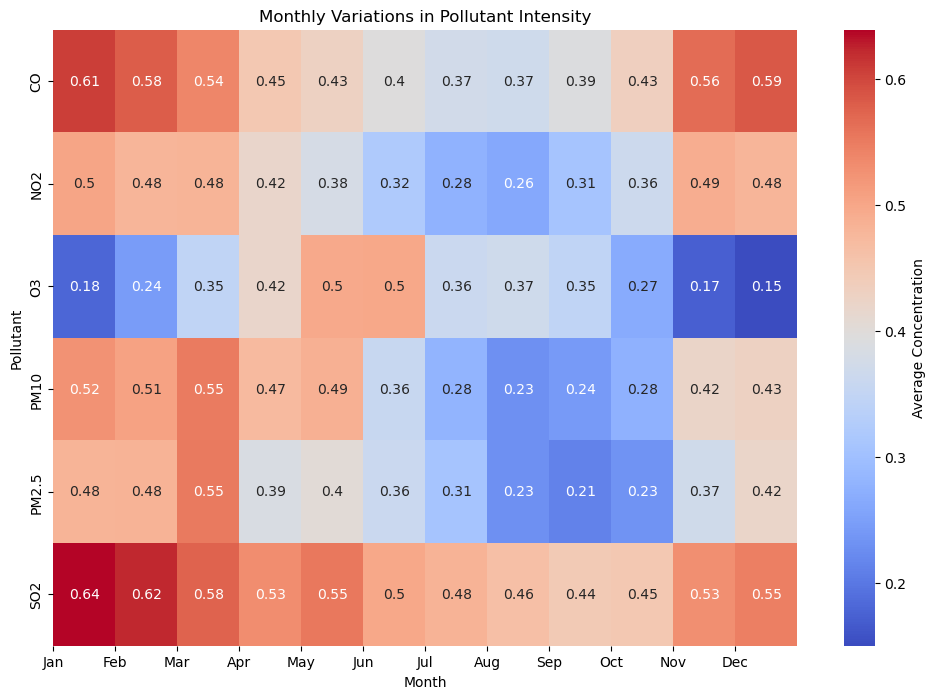

In [50]:
# Generate heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    monthly_pivot,
    cmap='coolwarm',
    cbar_kws={'label': 'Average Concentration'},
    annot=True
)
plt.title("Monthly Variations in Pollutant Intensity")
plt.xlabel("Month")
plt.ylabel("Pollutant")
plt.xticks(range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [53]:
cluster_files = [
    'CO_Hierarchical_Clusters.geojson',
    'NO2_Hierarchical_Clusters.geojson',
    'O3_Hierarchical_Clusters.geojson',
    'PM2.5_Hierarchical_Clusters.geojson',
    'PM10_Hierarchical_Clusters.geojson',
    'SO2_Hierarchical_Clusters.geojson'
]

In [54]:
# Combine all cluster data
all_clusters = []
for pollutant, file in zip(pollutants, cluster_files):
    gdf = gpd.read_file(file)
    gdf['Pollutant'] = pollutant
    all_clusters.append(gdf)

In [55]:
# Combine all pollutants into one GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(all_clusters, ignore_index=True))
combined_gdf['Centroid'] = combined_gdf.geometry.centroid

In [56]:
# Extract centroids and pollutant information
coordinates = np.array([(geom.x, geom.y) for geom in combined_gdf['Centroid']])
node_labels = combined_gdf.index  # Use index or cluster labels as nodes

In [57]:
# Step 2: Compute Pairwise Distances
threshold = 50  # Distance threshold in km
distances = cdist(coordinates, coordinates, metric='euclidean') * 111  # Convert degrees to km

In [58]:
# Step 3: Approximate Edge Set by Sampling
# Get valid edges (below threshold)
valid_edges = np.where((distances > 0) & (distances <= threshold))

In [71]:
# Randomly sample a subset of edges
sample_size = 100000  # Adjust based on memory and graph size needs
sample_indices = random.sample(range(len(valid_edges[0])), sample_size)

In [72]:
# Initialize network graph
G = nx.Graph()

In [73]:
# Add nodes
for i, coord in enumerate(coordinates):
    G.add_node(i, pos=(coord[0], coord[1]), pollutant=combined_gdf.loc[i, 'Pollutant'])

In [74]:
# Add sampled edges
for idx in sample_indices:
    s, t = valid_edges[0][idx], valid_edges[1][idx]
    G.add_edge(s, t, weight=1 / distances[s, t])

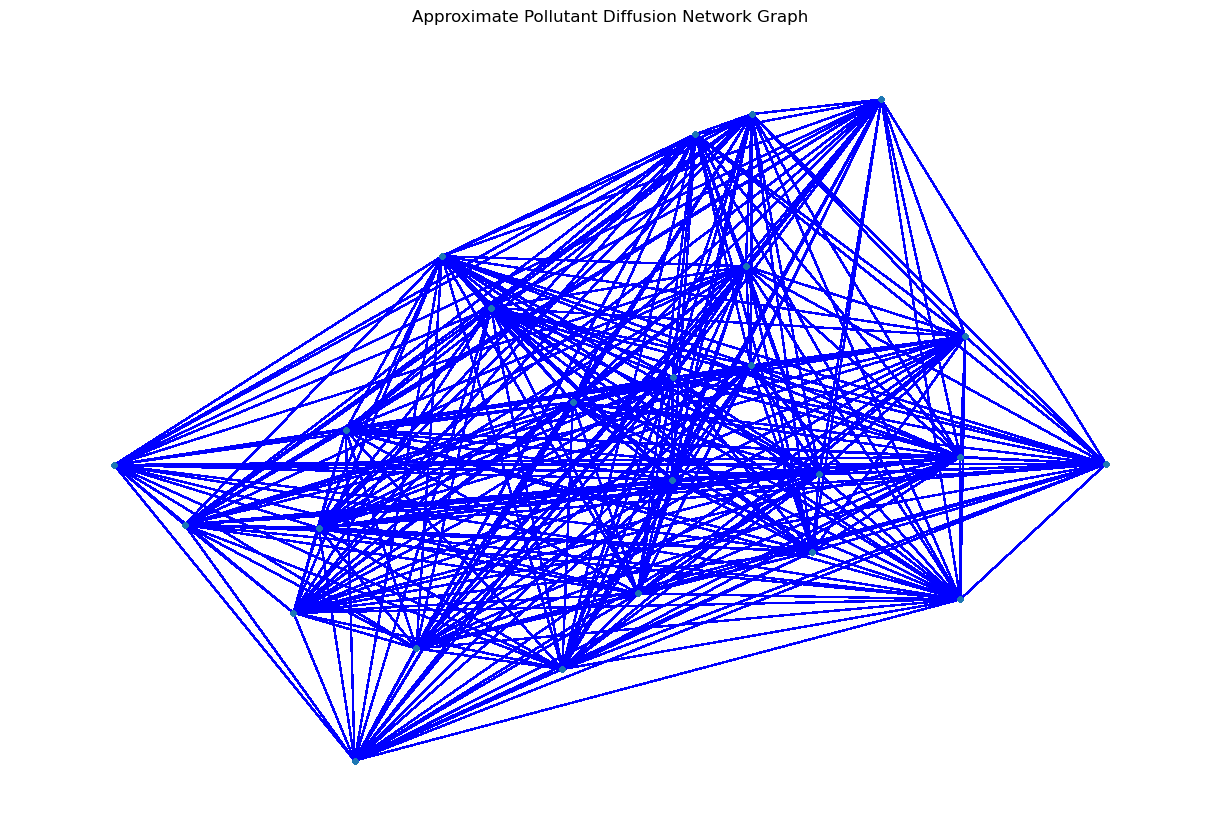

In [75]:
# Step 4: Visualize the Network Graph
plt.figure(figsize=(12, 8))
pos = {i: (coord[0], coord[1]) for i, coord in enumerate(coordinates)}  # Position nodes by coordinates
nx.draw(G, pos, with_labels=False, node_size=10, alpha=0.7, edge_color='blue')
plt.title("Approximate Pollutant Diffusion Network Graph")
plt.show()

In [116]:
# Filter significant Local Moran's I results for High-High and Low-Low clusters
hotspots = local_moran_df[
    (local_moran_df['Significant']) & (local_moran_df['Local_I'] > 0)
]

cold_spots = local_moran_df[
    (local_moran_df['Significant']) & (local_moran_df['Local_I'] < 0)
]

# Count hotspots and cold spots by pollutant
hotspot_counts = hotspots.groupby('Pollutant')['Station code'].count()
coldspot_counts = cold_spots.groupby('Pollutant')['Station code'].count()

print("Hotspot Counts by Pollutant:")
print(hotspot_counts)

print("Cold Spot Counts by Pollutant:")
print(coldspot_counts)

Hotspot Counts by Pollutant:
Pollutant
CO       2654
NO2      3243
O3       4367
PM10     2415
PM2.5    2755
SO2      2154
Name: Station code, dtype: int64
Cold Spot Counts by Pollutant:
Pollutant
CO       1666
NO2      1510
O3       1180
PM10     1651
PM2.5    1679
SO2      1546
Name: Station code, dtype: int64


In [117]:
print(hotspots.head())

         Date  Station code Pollutant   Local_I  Significant
7  2017-01-01           108       SO2  0.684697         True
32 2017-01-01           108       NO2  0.165279         True
52 2017-01-01           103        O3  0.776408         True
58 2017-01-01           109        O3  0.635830         True
75 2017-01-01           101        CO  0.118744         True


In [118]:
# Merge station coordinates with hotspots and cold spots
stations = gdf[['Station code', 'Latitude', 'Longitude']]  # Assuming `gdf` has station details
stations = stations.drop_duplicates(subset=['Station code'])

In [119]:
# Keep only necessary columns in hotspots
hotspots = hotspots[['Date', 'Station code', 'Pollutant', 'Local_I', 'Significant']]
cold_spots = cold_spots[['Date', 'Station code', 'Pollutant', 'Local_I', 'Significant']]

In [120]:
# Initialize an empty DataFrame for the merged result
merged_hotspots = []

# Merge in chunks
chunk_size = 10000  # Adjust based on available memory
for start_idx in range(0, len(hotspots), chunk_size):
    chunk = hotspots.iloc[start_idx:start_idx + chunk_size]
    merged_chunk = chunk.merge(stations, on='Station code', how='left')
    merged_hotspots.append(merged_chunk)

# Combine all chunks into a single DataFrame
hotspots = pd.concat(merged_hotspots, ignore_index=True)

In [121]:
# Perform a chunked merge for cold_spots
merged_cold_spots = []
chunk_size = 10000  # Adjust chunk size based on available memory
for start_idx in range(0, len(cold_spots), chunk_size):
    chunk = cold_spots.iloc[start_idx:start_idx + chunk_size]
    merged_chunk = chunk.merge(stations, on='Station code', how='left')
    merged_cold_spots.append(merged_chunk)

# Combine chunks into a single DataFrame
cold_spots = pd.concat(merged_cold_spots, ignore_index=True)

In [125]:
# Drop outdated or unnecessary columns
hotspots = hotspots.drop(columns=['Latitude', 'Longitude'], errors='ignore')

# Perform the merge
hotspots = hotspots.merge(stations[['Station code', 'Latitude', 'Longitude']], on='Station code', how='left')

In [126]:
# Drop outdated or unnecessary columns
cold_spots = cold_spots.drop(columns=['Latitude', 'Longitude'], errors='ignore')

# Merge `cold_spots` with `stations` to get latitude and longitude
cold_spots = cold_spots.merge(stations[['Station code', 'Latitude', 'Longitude']], on='Station code', how='left')

In [127]:
hotspots.head()

Date  Station code Pollutant   Local_I  Significant  Latitude_x  \
0 2017-01-01           108       SO2  0.684697         True   37.547180   
1 2017-01-01           108       NO2  0.165279         True   37.547180   
2 2017-01-01           103        O3  0.776408         True   37.540033   
3 2017-01-01           109        O3  0.635830         True   37.575743   
4 2017-01-01           101        CO  0.118744         True   37.572016   

   Longitude_x  Latitude_y  Longitude_y   Latitude   Longitude  
0   127.092493   37.547180   127.092493  37.547180  127.092493  
1   127.092493   37.547180   127.092493  37.547180  127.092493  
2   127.004850   37.540033   127.004850  37.540033  127.004850  
3   127.028885   37.575743   127.028885  37.575743  127.028885  
4   127.005008   37.572016   127.005008  37.572016  127.005008

In [128]:
cold_spots.head()

Date  Station code Pollutant   Local_I  Significant  Latitude_x  \
0 2017-01-01           118       SO2 -0.518746         True   37.452357   
1 2017-01-01           124       SO2 -0.082109         True   37.502686   
2 2017-01-01           106        O3 -0.033272         True   37.555580   
3 2017-01-01           111      PM10 -1.465914         True   37.606719   
4 2017-01-01           112     PM2.5 -1.465659         True   37.647930   

   Longitude_x  Latitude_y  Longitude_y   Latitude   Longitude  
0   126.908296   37.452357   126.908296  37.452357  126.908296  
1   127.092509   37.502686   127.092509  37.502686  127.092509  
2   126.905597   37.555580   126.905597  37.555580  126.905597  
3   127.027279   37.606719   127.027279  37.606719  127.027279  
4   127.011952   37.647930   127.011952  37.647930  127.011952

In [129]:
cold_spots = cold_spots[['Date', 'Station code', 'Pollutant', 'Local_I', 'Significant','Latitude', 'Longitude']]
hotspots = hotspots[['Date', 'Station code', 'Pollutant', 'Local_I', 'Significant','Latitude', 'Longitude']]

In [130]:
cold_spots.head()

Date  Station code Pollutant   Local_I  Significant   Latitude  \
0 2017-01-01           118       SO2 -0.518746         True  37.452357   
1 2017-01-01           124       SO2 -0.082109         True  37.502686   
2 2017-01-01           106        O3 -0.033272         True  37.555580   
3 2017-01-01           111      PM10 -1.465914         True  37.606719   
4 2017-01-01           112     PM2.5 -1.465659         True  37.647930   

    Longitude  
0  126.908296  
1  127.092509  
2  126.905597  
3  127.027279  
4  127.011952

In [131]:
hotspots.head()

Date  Station code Pollutant   Local_I  Significant   Latitude  \
0 2017-01-01           108       SO2  0.684697         True  37.547180   
1 2017-01-01           108       NO2  0.165279         True  37.547180   
2 2017-01-01           103        O3  0.776408         True  37.540033   
3 2017-01-01           109        O3  0.635830         True  37.575743   
4 2017-01-01           101        CO  0.118744         True  37.572016   

    Longitude  
0  127.092493  
1  127.092493  
2  127.004850  
3  127.028885  
4  127.005008

In [132]:
# Convert `hotspots` to GeoDataFrame
hotspots_gdf = gpd.GeoDataFrame(
    hotspots, 
    geometry=gpd.points_from_xy(hotspots['Longitude'], hotspots['Latitude']),
    crs="EPSG:4326"  # Assign CRS (WGS 84)
)

# Convert `cold_spots` to GeoDataFrame
cold_spots_gdf = gpd.GeoDataFrame(
    cold_spots, 
    geometry=gpd.points_from_xy(cold_spots['Longitude'], cold_spots['Latitude']),
    crs="EPSG:4326"  # Assign CRS (WGS 84)
)

<Figure size 1200x800 with 0 Axes>

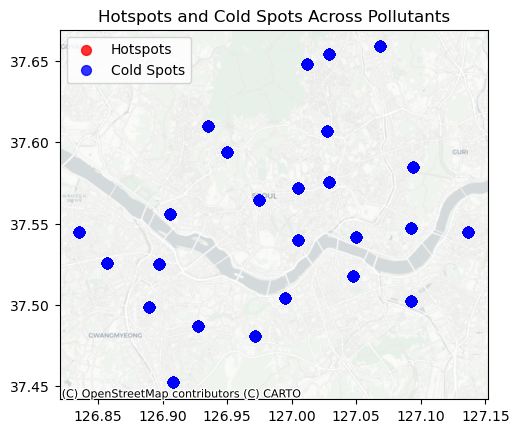

In [134]:
# Plot hotspots and cold spots for all pollutants
plt.figure(figsize=(12, 8))
ax = hotspots_gdf.plot(color='red', label='Hotspots', markersize=50, alpha=0.8)
cold_spots_gdf.plot(ax=ax, color='blue', label='Cold Spots', markersize=50, alpha=0.8)
ctx.add_basemap(ax, crs=hotspots_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.legend()
plt.title("Hotspots and Cold Spots Across Pollutants")
plt.show()

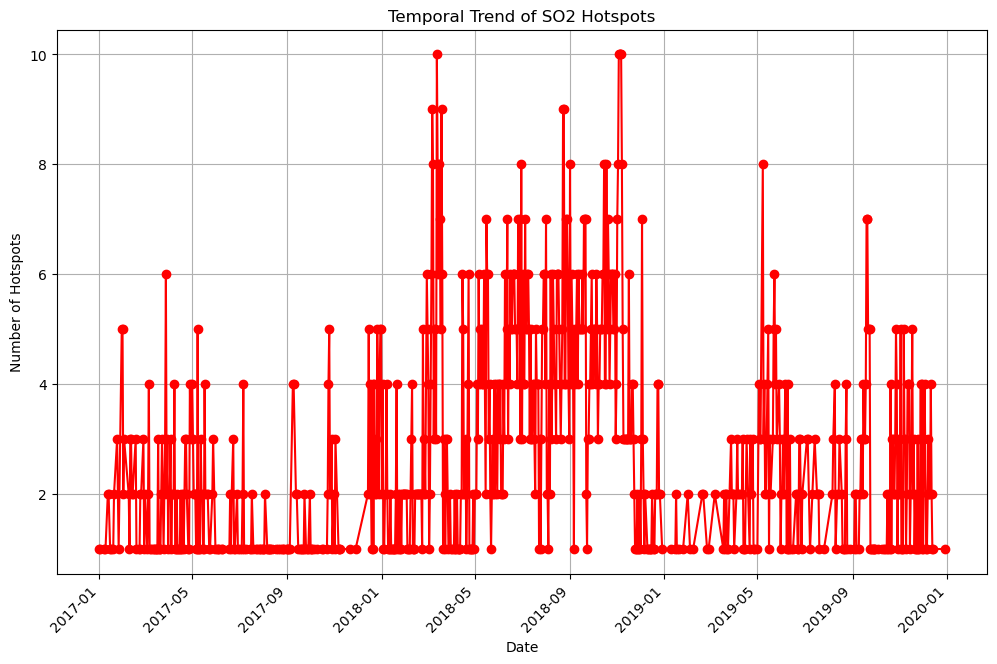

In [135]:
# Example: Temporal trend of hotspots for a specific pollutant
pollutant = 'SO2'  # Replace with desired pollutant
hotspots_over_time = hotspots[
    (hotspots['Pollutant'] == pollutant)
].groupby('Date')['Station code'].count()

plt.figure(figsize=(12, 8))
hotspots_over_time.plot(kind='line', marker='o', color='red')
plt.title(f"Temporal Trend of {pollutant} Hotspots")
plt.xlabel("Date")
plt.ylabel("Number of Hotspots")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [136]:
# Add hotspot and cold spot information as node attributes in the network graph
for idx, row in hotspots.iterrows():
    station = row['Station code']
    if station in G.nodes:
        G.nodes[station]['is_hotspot'] = True

for idx, row in cold_spots.iterrows():
    station = row['Station code']
    if station in G.nodes:
        G.nodes[station]['is_coldspot'] = True


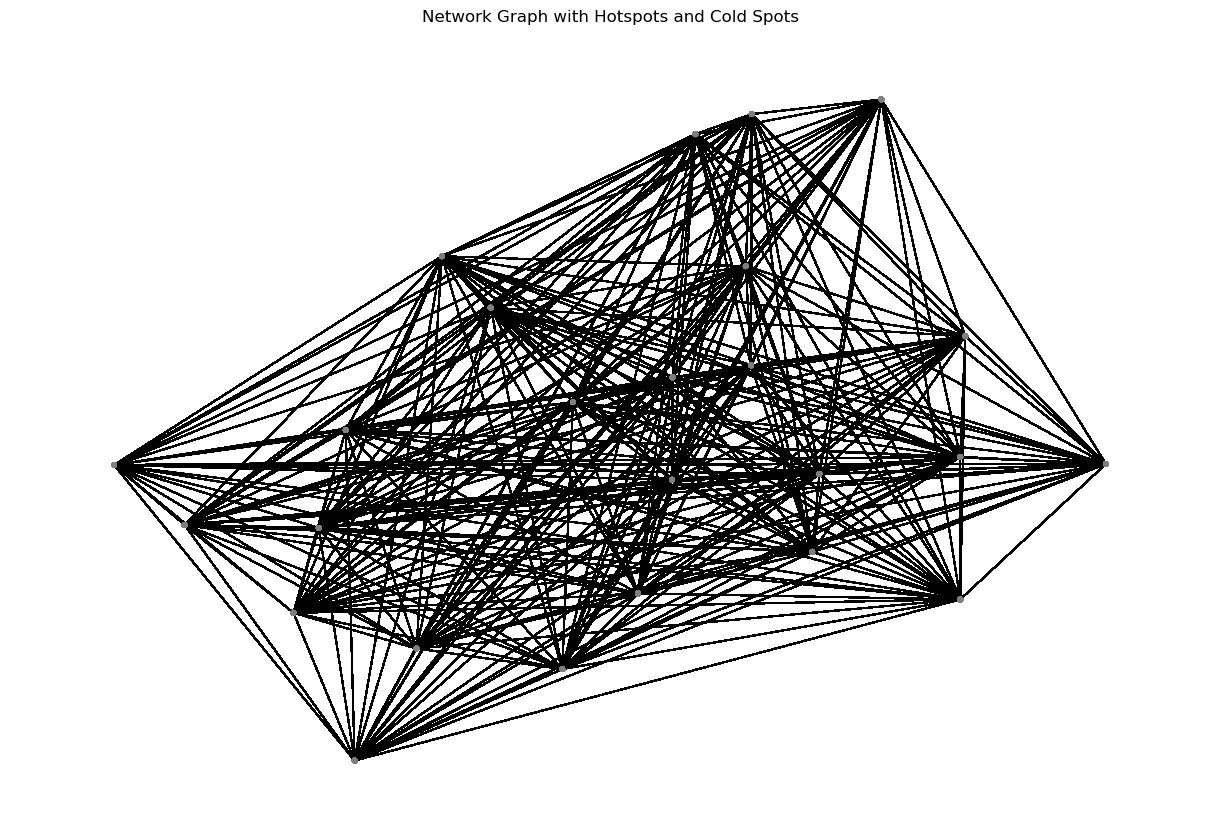

In [137]:
# Visualize network graph with hotspot and cold spot annotations
plt.figure(figsize=(12, 8))
pos = nx.get_node_attributes(G, 'pos')  # Node positions
node_colors = [
    'red' if G.nodes[node].get('is_hotspot') else 'blue' if G.nodes[node].get('is_coldspot') else 'gray'
    for node in G.nodes
]
nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=10, alpha=0.8)
plt.title("Network Graph with Hotspots and Cold Spots")
plt.show()

In [143]:
# Compute overall averages for each pollutant at each station
long_term_avg = daily_data.groupby('Station code').mean().reset_index()

# Merge with station data
station_avg = gdf.merge(long_term_avg, on='Station code')

In [140]:
# Add month and season columns
daily_data['Month'] = daily_data['Date'].dt.month
daily_data['Season'] = daily_data['Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, etc.

# Compute monthly averages
monthly_avg = daily_data.groupby(['Station code', 'Month']).mean().reset_index()

# Compute seasonal averages
seasonal_avg = daily_data.groupby(['Station code', 'Season']).mean().reset_index()

In [141]:
# Example: Use SO2 long-term averages to compute edge weights
coordinates = gdf[['Latitude', 'Longitude']].to_numpy()
distances = cdist(coordinates, coordinates, metric='euclidean') * 111  # Convert degrees to km
threshold = 50  # Distance threshold in km


In [144]:
edges = []
for i in range(len(gdf)):
    for j in range(len(gdf)):
        if i != j:
            distance = distances[i, j]
            if distance <= threshold:
                similarity = 1 / (1 + abs(station_avg.loc[i, 'SO2'] - station_avg.loc[j, 'SO2']))
                weight = (1 / distance) * similarity
                edges.append((station_avg.loc[i, 'Station code'], station_avg.loc[j, 'Station code'], weight))

In [145]:
# Example: Compute seasonal network graphs
seasonal_graphs = {}

for season in seasonal_avg['Season'].unique():
    season_data = seasonal_avg[seasonal_avg['Season'] == season]
    coordinates = season_data[['Latitude', 'Longitude']].to_numpy()
    distances = cdist(coordinates, coordinates, metric='euclidean') * 111
    
    edges = []
    for i in range(len(season_data)):
        for j in range(len(season_data)):
            if i != j:
                distance = distances[i, j]
                if distance <= threshold:
                    similarity = 1 / (1 + abs(season_data.iloc[i]['SO2'] - season_data.iloc[j]['SO2']))
                    weight = (1 / distance) * similarity
                    edges.append((season_data.iloc[i]['Station code'], season_data.iloc[j]['Station code'], weight))
    # Create a graph for this season
    G_season = nx.Graph()
    G_season.add_weighted_edges_from(edges)
    seasonal_graphs[season] = G_season

KeyError: "None of [Index(['Latitude', 'Longitude'], dtype='object')] are in the [columns]"